<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_06_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Regular Dropout

In [2]:
# Define a dropout instance and create some data
# define the probability
prob = 0.5 # default

dropout = nn.Dropout(p=prob)
dropout

Dropout(p=0.5, inplace=False)

In [3]:
# Lets see what dropout returns
x = torch.ones(10)

y = dropout(x)
print(x)
print()
print(y) # y/(1-p), SCALED UP
print()
print(torch.mean(y))
# Independent probabilities

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([0., 0., 2., 0., 2., 0., 2., 0., 2., 2.])

tensor(1.)


In [4]:
# dropout is turned off when evaluating the model
dropout.eval()
# All lines within its identation will have dropout mode off
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [5]:
# Another way to use dropout is to use F.dropout()
dropout.eval()
y = F.dropout(x) # no need to specify instance
print(y)
print()
print(torch.mean(y))

tensor([0., 0., 2., 2., 2., 0., 0., 2., 0., 0.])

tensor(0.8000)


In [6]:
# We can manually switch it off with F
dropout.eval()
y = F.dropout(x, training=False)
print(y)
print()
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor(1.)


In [7]:
# When a model is switched to eval mode it stays in it until it is switched back to training mode
dropout.train()
y = dropout(x)
print(y)
print()

dropout.eval()
y = dropout(x)
print(y)
print()

# dropout.train()
y = dropout(x) # will still be in eval unless dropout.train() is activated
print(y)

tensor([2., 0., 0., 0., 2., 2., 2., 0., 0., 0.])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Drop-Out Regularization

In [8]:
# Load all the additional libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [15]:
# The data is not linearly separable and DL is not necessary, but here we do it for practical purposes
nPerClust = 200

# define the angles
th = np.linspace(0, 4*np.pi, nPerClust)

# define the radii
r1 = 10
r2 = 15

# generate the data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3,
      r1*np.sin(th) + np.random.randn(nPerClust)]

b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

# Define the true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

[print(len(i)) for i in a]
print()
[print(len(i)) for i in b]
print()
print(labels_np.shape)

200
200

200
200

(400, 1)


In [16]:
# Concatenate into a single matrix
data_np = np.hstack((a,b)).T

# Convert to Tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

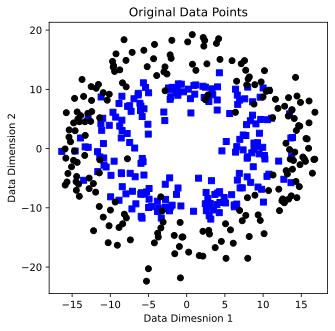

In [21]:
# Plot the whole thing
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs")
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko")
plt.title("Original Data Points")
plt.xlabel("Data Dimesnion 1")
plt.ylabel("Data Dimension 2")
plt.show()

In [23]:
# Separate the data into data loaders
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert them to pytpruch datasets, they are a;ready tensors
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Convert them to dataloader objects
batchsize=16 # int(train_data.tensors[0].shape[0]/4) for soft coding
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [31]:
# Create the model class
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        # Layers
        self.input  = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128,1)

        # Parameters
        self.dr = dropoutRate

    # Define forward pass
    def forward(self,x):

        # Pass the data through the input layer
        x = F.relu(self.input(x))

        # Dropout after input layer
        x = F.dropout(x, p=self.dr, training=self.training) # No need to set to true or false every time

        # Pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # Dropout after hidden layer
        x = F.dropout(x, p=self.dr, training=self.training)

        # Outout layer
        x = self.output(x) # No dropout here

        return x